<a href="https://colab.research.google.com/github/msrepo/2d3d/blob/master/notebook/DeepFLASH_supervised_deformable_image_registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
%%capture
!git clone https://github.com/RISE-MICCAI/AI-in-Medical-Imaging-Winter-2022-School.git
!pip install SimpleITK
!pip install torch==1.10.1+cu102 torchvision==0.11.2+cu102 torchaudio==0.10.1 -f https://download.pytorch.org/whl/cu102/torch_stable.html

In [54]:
import sys
sys.path.append('/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Code')

In [55]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import torch

import uEpdiff 
import Reg_Tools 

In [56]:
src = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata/src3d/src1.mhd"
tar = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata/tar3d/tar1.mhd"


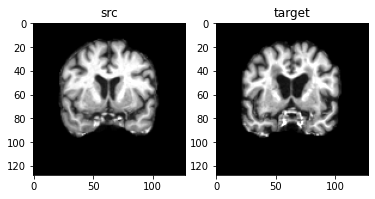

In [57]:
src_itk_img = sitk.ReadImage(src)
src_np_img = sitk.GetArrayFromImage(src_itk_img)

target_itk_img = sitk.ReadImage(tar)
target_np_img = sitk.GetArrayFromImage(target_itk_img)

fig,ax = plt.subplots(1,2)
for i,(np_img,title) in enumerate(zip([src_np_img, target_np_img],['src','target'])):
  ax[i].imshow(np_img[80], cmap='gray',clim=np.percentile(np_img, (1,99)))
  ax[i].set_title(title)
plt.show()

In [58]:
if torch.cuda.is_available():
  dev = 'cuda'
else:
  dev = 'cpu'
device = torch.device(dev)

net = Reg_Tools.getUnetT3D()
Reg_Tools.loadParameter(net,'/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Code/PretrainedReg.tar',device=device)
net.to(device)

VxmDense(
  (unet_model): Unet(
    (pooling): ModuleList(
      (0): Conv3d(16, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): Conv3d(64, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (upsampling): ModuleList(
      (0): ConvTranspose3d(64, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ConvTranspose3d(64, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): PReLU(num_parameters=16)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): PReLU(num_parameters=64)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main):

In [59]:
with torch.no_grad():
  # load source and target image, then predict momentum using NN

  src = torch.from_numpy(src_np_img).to(device)
  target = torch.from_numpy(target_np_img).to(device)

  # transpose axis to match input orientation with the training data
  src = src.permute(2,1,0).unsqueeze(0) # (1,128,128,128)
  target = target.permute(2,1,0).unsqueeze(0)

  model_input = torch.stack((src,target),dim=1) # (1,2,128,128,128)

  predicted_momentum = net(model_input) # (1,3,128,128,128)
  predicted_momentum = predicted_momentum.permute(0,4,3,2,1).squeeze(0) # (3,128,128,128)

# start shooting and deform

In [60]:
imagesize = 128
truncate = 16
identity = Reg_Tools.get_grid2(imagesize,device).permute([0,4,3,2,1]) # (1,3,128,128,128) -> (1,128,128,128,3)
epdiff = uEpdiff.Epdiff(device,(truncate,)*3, (imagesize,)*3, alpha=2.0, gamma=1.0, lpow=4)

# momentum to velocity
velocity = epdiff.fourier2spatial(epdiff.Kcoeff * epdiff.spatial2fourier(predicted_momentum))
sitk.WriteImage(sitk.GetImageFromArray(velocity.cpu().numpy()),'/content/velocity0.nii.gz')

In [61]:
# run geodesic shooting with initial velocity
# results: 10-steps of velocity fields and displacement

num_steps = 10
v_seq, displacement = epdiff.forward_shooting_v_and_phiinv(velocity,num_steps) # displacement (128,128,128,3)

# phiinv should add identity transformation
phiinv = displacement.unsqueeze(0) + identity

# interpolate src with phiinv
dfm = Reg_Tools.Torchinterp(src.unsqueeze(0),phiinv) # CHWD->BCHWD
sitk.WriteImage(sitk.GetImageFromArray(dfm.cpu().numpy()),'deformed_src.nii.gz')


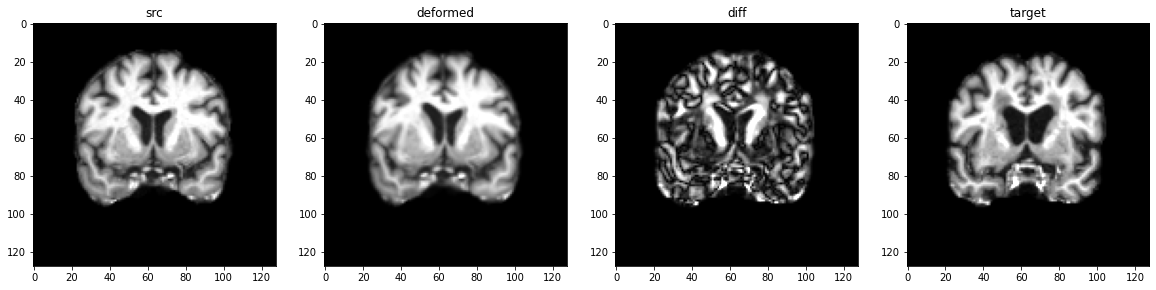

In [72]:
src_np = src[0].permute(2,1,0)
dfm_np = dfm[0,0].permute(2,1,0)
target_np = target[0].permute(2,1,0)
diff = np.abs(target_np - dfm_np)
fig,ax = plt.subplots(1,4,figsize=(20,10))
for i,(np_img,title) in enumerate(zip([src_np, dfm_np, diff, target_np],['src','deformed','diff','target'])):
  ax[i].imshow(np_img[80], cmap='gray',clim=np.percentile(np_img, (1,99)))
  ax[i].set_title(title)
plt.show()